# Plane wall with Dirichlet boundary conditions

Flow rate / m²:
q_n = -14.57 W/m² - numerical solution
q_a = -14.57 W/m² - analytical solution
q_m = -14.57 W/m² - solution using mean conductivity


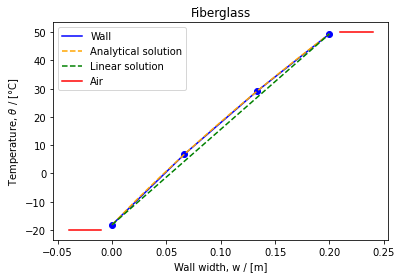

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 18 09:08:28 2023

Variable conductivity with temperature
Linear model

λ(θ) = λ0 * (1 + β * (θ - θ0))

Convection surface conditions: h0*(T0 - θ[0]); h1*(T1 - θ[-1]):
    - h0, h1 - W/(m·K²), convection coefficients
    - T0, T1 - °C, ambiance temperatures
    - θ[0], θ[-1] - °C, temeprature of 1st and last node

Conductivity
λ(T) = λ0 * (1 + β * (T - Tb))

Numerical model:
Given:
    - ambiance temperatures T0 and T1
    - base temperature Tb in λ(T) = λ0 * (1 + β * (T - Tb))
    - coefficients a, b of the fitted linear model λ(T) = a * T + b
    - w, width of plane wall
    - nb, number of branches

The model is:

T0-G0-*-G1-*...*-Gnb-T1

Experimental data from
U. Berardi et al.(2018) On the Effects of Variation of Thermal Conductivity in
Buildings in the Italian Construction Sector, Energies, 11(4), 872
 https://doi.org/10.3390/en11040872
"""
import numpy as np
import matplotlib.pyplot as plt


def var_cond_dirichlet_bc(x):
    """
    Numerical solution to a plane wall with Dirichlet boundary conditions
    when conductivity varies with temperature: λ(T) = λ0 * (1 + β * (T - Tb))

    Parameters
    ----------
    x : TYPE list
        λ0  - W/(m·K), conductivity for base temperature T = Tb
        β   - W/(m·K²), temperature coefficient in λ = λ(T)
        w   - m, width of the plane wall
        h0  - W/(m·K²), convection coefficient
        h1  - W/(m·K²), convection coefficient
        T0  - °C, ambiance temperature on boundary x = 0
        T1  - °C, ambiance temperature on boundary x = w
        Tb  - °C, base temperature in λ = λ(T)
        nb  - number of branches in material

    Returns
    -------
    y : TYPE list
        θ   - °C, temperature at nodes w/(nb - 1)
        q   - W/m², heat flux
    """

    λ0, β, Tb, h0, h1, T0, T1, w, nb = x

    A = -np.diff(np.eye(nb + 2))
    b = np.zeros(nb + 2)
    b[0], b[-1] = T0, -T1
    f = np.zeros(nb + 1)

    # initial temperature distribution estimated with constant conductivity
    Gm = λ0 / (w / nb) * np.ones(nb)     # in material
    G = np.diag(np.concatenate(([h0], Gm, [h1])))
    θ0 = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

    ε = 0.01  # °C, acceptable error
    not_convergent = True

    while not_convergent:
        # θ_b = np.concatenate(([T0], θ0, [T1]))
        θ_mean = (θ0[:-1] + θ0[1:]) / 2
        λm = λ0 * (1 + β * (θ_mean - Tb))
        Gm = λm / (w / nb)
        G = np.diag(np.concatenate(([h0], Gm, [h1])))
        θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

        not_convergent = max(abs(θ0 - θ)) > ε
        θ0 = θ

    q = G @ (-A @ θ + b)
    return θ, q


# Data
w = 0.20                    # m, width of the plane wall
nb = 3                      # number of branches, nb > 1
h0, h1 = 8, 25              # W/(m·K²), convection coefficient
T0, T1 = -20, 50            # °C, boundary temperatures
Tb = 20                     # °C, mean (base) temperature
a, b = 0.0002, 0.04         # coefficients of fitted model λ(T) = a * T + b

# parameters of model λ(T) = λ0 * (1 + β * (T - Tb))
λ0 = b + a * Tb
β = a / (b + a * Tb)

# Numerical solution
x = λ0, β, Tb, h0, h1, T0, T1, w, nb
θ_n, q_n = var_cond_dirichlet_bc(x)

# Analytical solution
x_a = np.linspace(0, w, 10)

θ0, θ1 = θ_n[[0, -1]]

C = (θ1 - θ0) / w * (1 + β * ((θ1 + θ0) / 2 - Tb))
q_a = - λ0 * C
θ_a = -1 / β + np.sqrt((1 / β + θ0 - Tb)**2 + 2 * C / β * x_a) + Tb

# Solution using average conductivity
λm = λ0 * (1 + β * ((θ0 + θ1) / 2 - Tb))
q_m = λm / w * (θ0 - θ1)

print('Flow rate / m²:')
print(f'q_n = {q_n[0]:.2f} W/m² - numerical solution')
print(f'q_a = {q_a:.2f} W/m² - analytical solution')
print(f'q_m = {q_m:.2f} W/m² - solution using mean conductivity')

# Plot results
x_n = np.linspace(0, w, nb + 1)     # conDuction
w_bl = 0.010                        # width of boundary layer
x_v = np.array([x_n[0] - w_bl, x_n[-1] + w_bl])
x_v = np.array(
    [x_n[0] - 4 * w_bl, x_n[0] - w_bl, x_n[-1] + w_bl, x_n[-1] + 4 * w_bl])

fig, ax = plt.subplots()
ax.scatter(x_n, θ_n,
           color='blue', marker='o')
ax.plot(x_n, θ_n,
        label='Wall', color='blue')
# ax.scatter(x_v, [T0, T0, T1, T1],
#            label='Ambiance', color='red', marker='*')
ax.plot(x_a, θ_a,
        label='Analytical solution', color='orange', linestyle='--')
ax.plot([x_n[0], x_n[-1]], [θ_n[0], θ_n[-1]],
        label='Linear solution', color='green', linestyle='--')

ax.plot(x_v[0:2], [T0, T0],
        label='Air', color='red')
ax.plot(x_v[2:4], [T1, T1],
        color='red')

ax.set_title('Fiberglass')
ax.set_xlabel('Wall width, w / [m]')
ax.set_ylabel('Temperature, $\\theta$ / [°C]')
plt.legend()
plt.show()


Flow rate / m²:
q_n = -10.43550 W/m² - numerical solution
q_a = -10.43550 W/m² - analytical solution
q_m = -10.43550 W/m² - solution using mean conductivity


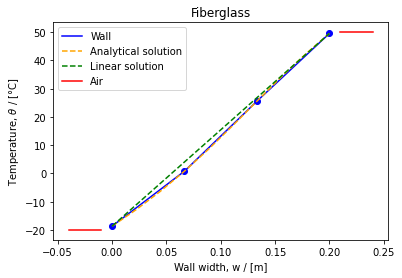

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 18 09:08:28 2023

ariable conductivity with temperature
Quadratic model for conductivity

λ(T) = λ0 * (1 + β * (T - Tb)²)

Convection surface conditions: h0*(T0 - θ[0]); h1*(T1 - θ[-1]):
    - h0, h1 - W/(m·K²), convection coefficients
    - T0, T1 - °C, ambiance temperatures
    - θ[0], θ[-1] - °C, temeprature of 1st and last node

Numerical model:
Given:
    - ambiance temperatures T0 and T1
    - base temperature Tb in λ(T) = λ0 * (1 + β * (T - Tb))
    - coefficients a, b of the fitted linear model λ(T) = a * T + b
    - w, width of plane wall
    - nb, number of branches

The model is:

T0-G0-*-G1-*...*-Gnb-T1

Experimental data from
U. Berardi et al.(2018) On the Effects of Variation of Thermal Conductivity in
Buildings in the Italian Construction Sector, Energies, 11(4), 872
 https://doi.org/10.3390/en11040872
"""
import numpy as np
import matplotlib.pyplot as plt


def var_cond_dirichlet_bc(x):
    """
    Numerical solution to a plane wall with Dirichlet boundary conditions
    when conductivity varies with temperature: λ(T) = λ0 * (1 + β * (T - Tb))

    Parameters
    ----------
    x : TYPE list
        λ0  - W/(m·K), conductivity for base temperature T = Tb
        β   - W/(m·K²), temperature coefficient in λ = λ(T)
        w   - m, width of the plane wall
        h0  - W/(m·K²), convection coefficient
        h1  - W/(m·K²), convection coefficient
        T0  - °C, ambiance temperature on boundary x = 0
        T1  - °C, ambiance temperature on boundary x = w
        Tb  - °C, base temperature in λ = λ(T)
        nb  - number of branches in material

    Returns
    -------
    y : TYPE list
        θ   - °C, temperature at nodes w/(nb - 1)
        q   - W/m², heat flux
    """

    λ0, β, Tb, h0, h1, T0, T1, w, nb = x

    A = -np.diff(np.eye(nb + 2))
    b = np.zeros(nb + 2)
    b[0], b[-1] = T0, -T1
    f = np.zeros(nb + 1)

    # initial temperature distribution estimated with constant conductivity
    Gm = λ0 / (w / nb) * np.ones(nb)     # in material
    G = np.diag(np.concatenate(([h0], Gm, [h1])))
    θ0 = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

    ε = 0.001  # °C, acceptable error
    not_convergent = True

    while not_convergent:
        θ_mean = (θ0[:-1] + θ0[1:]) / 2
        T_0, T_1 = θ0[:-1], θ0[1:]
        θ_mean = (T_0**2 + T_0 * T_1 + T_1**2) / 3 - Tb * (T_0 + T_1 - Tb)
        λm = λ0 * (1 + β * θ_mean)
        Gm = λm / (w / nb)
        G = np.diag(np.concatenate(([h0], Gm, [h1])))
        θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

        not_convergent = max(abs(θ0 - θ)) > ε
        θ0 = θ

    q = G @ (-A @ θ + b)
    return θ, q


# Data
w = 0.20                    # m, width of the plane wall
nb = 3                      # number of branches, nb > 1
h0, h1 = 8, 25              # W/(m·K²), convection coefficient
T0, T1 = -20, 50            # °C, boundary temperatures
Tb = 20                     # °C, mean (base) temperature
a, b, c = 8.364e-06, -3.857e-04, 3.128e-02  # fitted λ(T) = a·T² + b·T + c

# parameters of model λ(T) = λ0 * (1 + β * (T - Tb)^2)
λ0 = -(b**2 - 4 * a * c) / (4 * a)
β = - 4 * a**2 / (b**2 - 4 * a * c)
Tb = -b / (2 * a)           # °C, base temperature

# Numerical solution
x = λ0, β, Tb, h0, h1, T0, T1, w, nb
θ_n, q_n = var_cond_dirichlet_bc(x)

# Analytical solution
x_a = np.linspace(0, w, 10)

θ0, θ1 = θ_n[[0, -1]] - Tb

C = (θ1 - θ0) / w * (1 + β * (θ0**2 + θ0 * θ1 + θ1**2) / 3)
D = θ0 + β * θ0**3 / 3

b, c = 3 / β, -3 * (C * x_a + D) / β
bc = (27 * c / 2 + np.sqrt(108 * b**3 + 729 * c**2) / 2)**(1 / 3)
θ_a = b / bc - bc / 3
θ_a += Tb
q_a = - λ0 * C

# Solution using average conductivity
λm = λ0 * (1 + β * ((θ0**2 + θ0 * θ1 + θ1**2) / 3))
q_m = λm / w * (θ0 - θ1)

print('Flow rate / m²:')
print(f'q_n = {q_n[0]:.5f} W/m² - numerical solution')
print(f'q_a = {q_a:.5f} W/m² - analytical solution')
print(f'q_m = {q_m:.5f} W/m² - solution using mean conductivity')

# Plot results
x_n = np.linspace(0, w, nb + 1)     # conDuction
w_bl = 0.010                        # width of boundary layer
x_v = np.array([x_n[0] - w_bl, x_n[-1] + w_bl])
x_v = np.array(
    [x_n[0] - 4 * w_bl, x_n[0] - w_bl, x_n[-1] + w_bl, x_n[-1] + 4 * w_bl])

fig, ax = plt.subplots()
ax.scatter(x_n, θ_n,
           color='blue', marker='o')
ax.plot(x_n, θ_n,
        label='Wall', color='blue')
# ax.scatter(x_v, [T0, T0, T1, T1],
#            label='Ambiance', color='red', marker='*')
ax.plot(x_a, θ_a,
        label='Analytical solution', color='orange', linestyle='--')
ax.plot([x_n[0], x_n[-1]], [θ_n[0], θ_n[-1]],
        label='Linear solution', color='green', linestyle='--')

ax.plot(x_v[0:2], [T0, T0],
        label='Air', color='red')
ax.plot(x_v[2:4], [T1, T1],
        color='red')

ax.set_title('Fiberglass')
ax.set_xlabel('Wall width, w / [m]')
ax.set_ylabel('Temperature, $\\theta$ / [°C]')
plt.legend()
plt.show()
